In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

(32, 256, 256, 3)
[0 0 1 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 2 1 1 0 0 1 0 1 1 1 0 2 2]


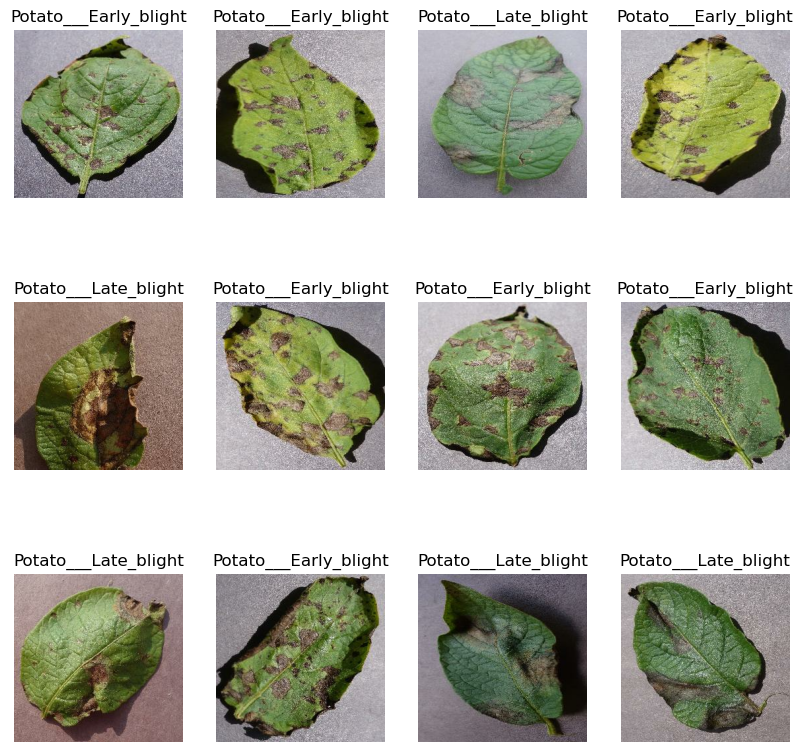

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

54 6 8


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 [==============================] - 100s 2s/step - loss: 0.9084 - accuracy: 0.5237 - val_loss: 0.8214 - val_accuracy: 0.6719
Epoch 2/10
54/54 [==============================] - 91s 2s/step - loss: 0.6602 - accuracy: 0.7043 - val_loss: 0.4528 - val_accuracy: 0.8073
Epoch 3/10
54/54 [==============================] - 71s 1s/step - loss: 0.4645 - accuracy: 0.8108 - val_loss: 0.2409 - val_accuracy: 0.9115
Epoch 4/10
54/54 [==============================] - 69s 1s/step - loss: 0.2969 - accuracy: 0.8744 - val_loss: 0.1751 - val_accuracy: 0.9479
Epoch 5/10
54/54 [==============================] - 69s 1s/step - loss: 0.2634 - accuracy: 0.8900 - val_loss: 0.1631 - val_accuracy: 0.9479
Epoch 6/10
54/54 [==============================] - 69s 1s/step - loss: 0.2602 - accuracy: 0.9068 - val_loss: 0.2076 - val_accuracy: 0.9167
Epoch 7/10
54/54 [==============================] - 69s 1s/step - loss: 0.1960 - accuracy: 0.9236 - val_loss: 0.0870 - val_accuracy: 0.9531
Epoch 8/10
54/54 [=

In [13]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 5s 424ms/step - loss: 0.1296 - accuracy: 0.9492


[0.12957227230072021, 0.94921875]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.9084330797195435,
 0.6601827144622803,
 0.46453821659088135,
 0.2968843877315521,
 0.263357937335968,
 0.2601690888404846,
 0.19596530497074127,
 0.11765771359205246,
 0.12635770440101624,
 0.15733496844768524]

In [16]:
history.history['accuracy']

[0.5237268805503845,
 0.7042824029922485,
 0.8107638955116272,
 0.8744212985038757,
 0.8900462985038757,
 0.9068287014961243,
 0.9236111044883728,
 0.9571759104728699,
 0.9456018805503845,
 0.9380787014961243]

In [17]:
history.history['val_loss']

[0.8214473724365234,
 0.45282164216041565,
 0.24086593091487885,
 0.17507325112819672,
 0.1631103903055191,
 0.2075696587562561,
 0.0869755670428276,
 0.09832241386175156,
 0.08435917645692825,
 0.08837816119194031]

In [18]:
history.history['val_accuracy']

[0.671875,
 0.8072916865348816,
 0.9114583134651184,
 0.9479166865348816,
 0.9479166865348816,
 0.9166666865348816,
 0.953125,
 0.9479166865348816,
 0.984375,
 0.96875]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

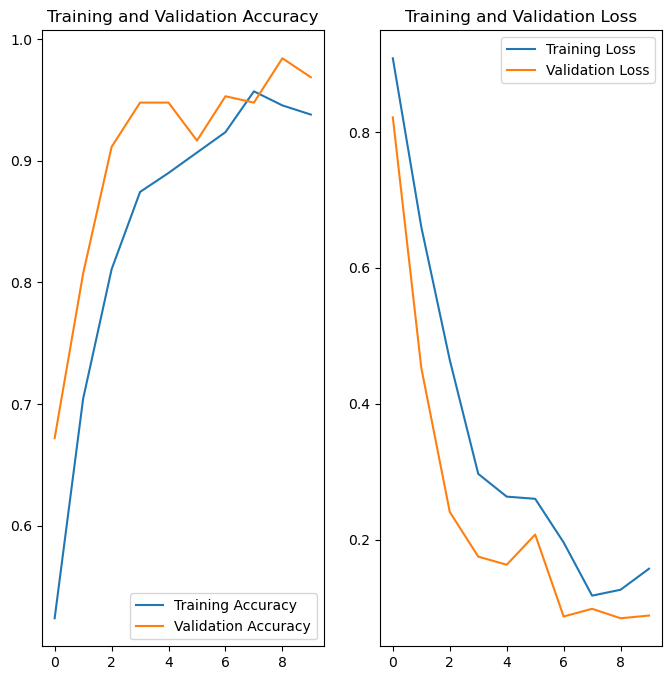

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(8):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 410ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 52ms/step


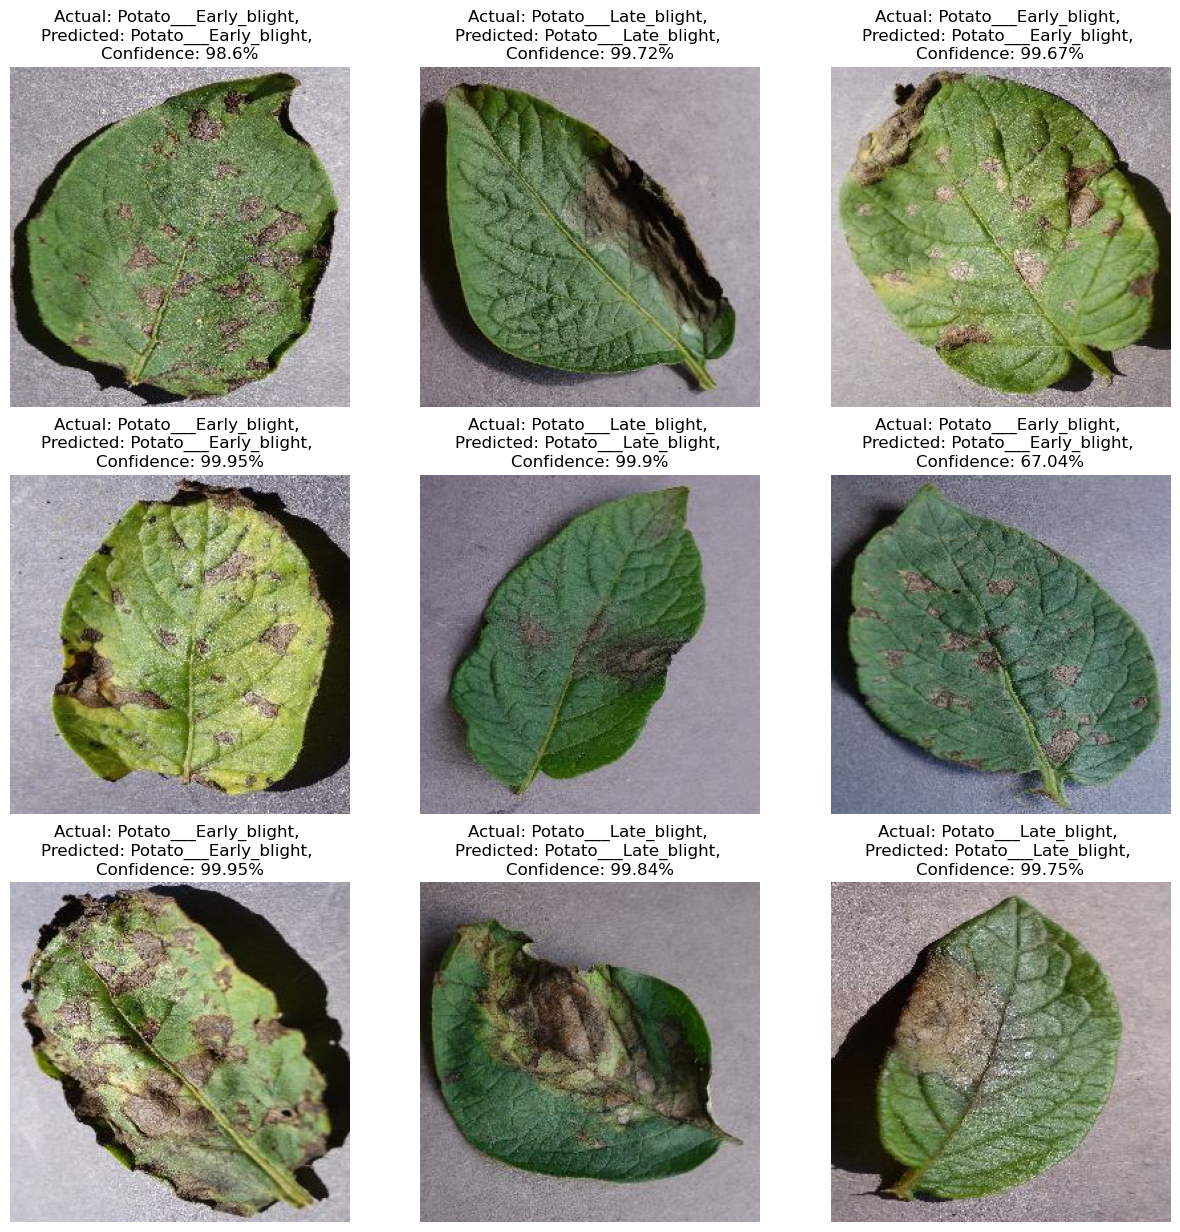

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       123
           1       0.96      0.92      0.94       115
           2       0.78      1.00      0.88        18

    accuracy                           0.95       256
   macro avg       0.90      0.96      0.93       256
weighted avg       0.95      0.95      0.95       256



In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[119,   4,   0],
       [  4, 106,   5],
       [  0,   0,  18]])>

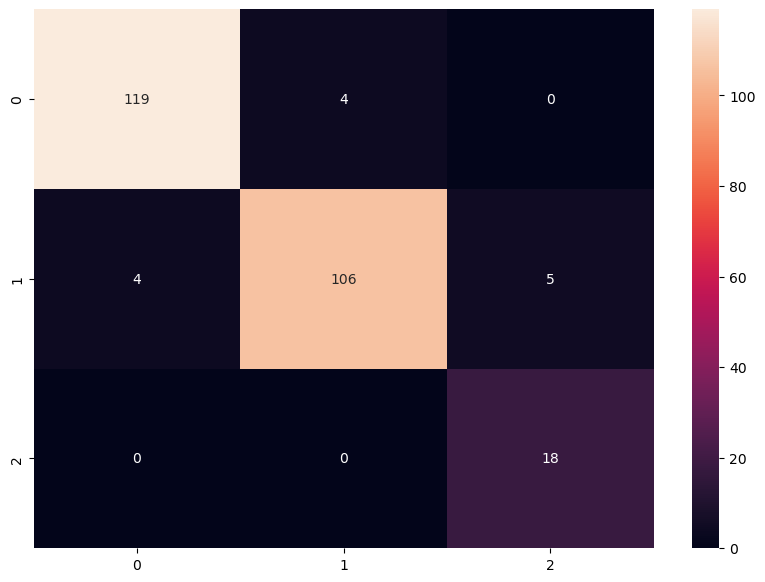

In [26]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [27]:
filename = "Model1-Epochs10.joblib"
joblib.dump(model, filename)

['Model1-Epochs10.joblib']